In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import yt
import cmasher as cmr
import matplotlib as mpl
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import AxesGrid, ImageGrid
from numpy import linspace
from cr_diffusion_tools import cr_spatial_covariance

# plot params
plt.rcParams["xtick.top"] = True 
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.direction"] = 'in' 
plt.rcParams["ytick.direction"] = 'in' 
plt.rcParams["xtick.minor.visible"] = True 
plt.rcParams["ytick.minor.visible"] = True 
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["xtick.minor.size"] = 4.5
plt.rcParams["ytick.major.size"] = 7
plt.rcParams["ytick.minor.size"] = 4.5
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
#plt.rcParams.update({"text.usetex": True})
#plt.style.use('dark_background')

In [2]:
# turn off silly warnings
yt.set_log_level("error")

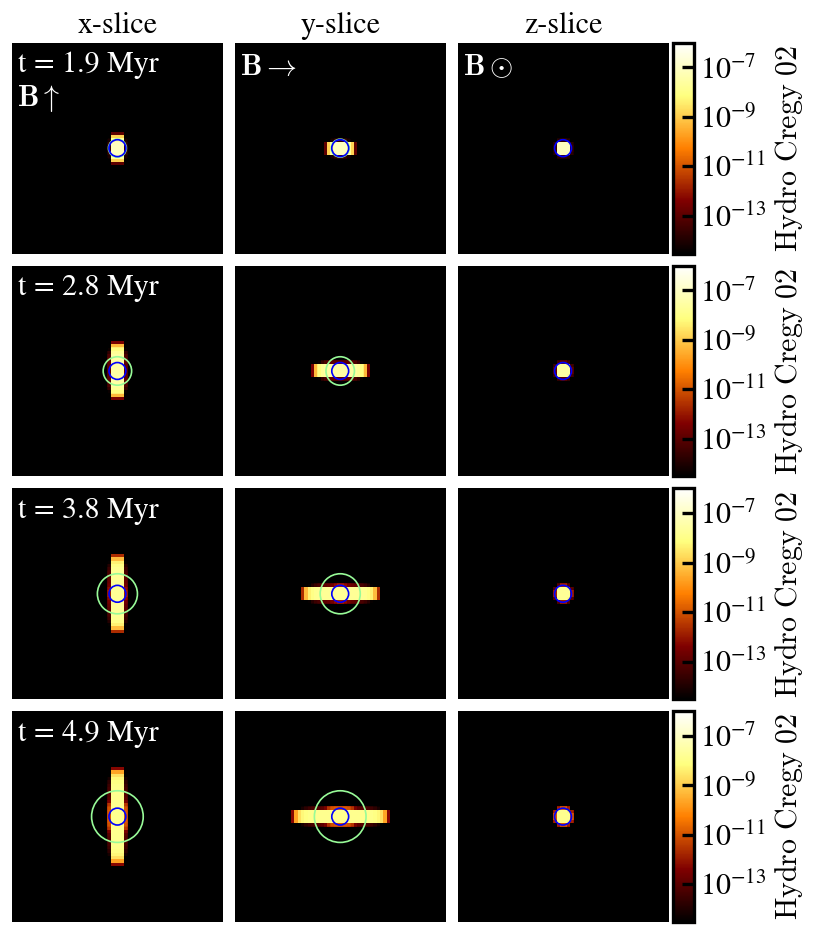

In [18]:
coords = ["x", "y", "z"]
title = ["x-slice", "y-slice", "z-slice"]
text = [r"$\mathbf{B} \uparrow$", r"$\mathbf{B} \rightarrow$", r"$\mathbf{B} \odot $"]
fns = [
    "/scratch/gpfs/ms0821/sampson_ramses/low_res_no_turb_stream/output_00022/info_00022.txt", 
    "/scratch/gpfs/ms0821/sampson_ramses/low_res_no_turb_stream/output_00032/info_00032.txt",
    "/scratch/gpfs/ms0821/sampson_ramses/low_res_no_turb_stream/output_00043/info_00043.txt", 
    "/scratch/gpfs/ms0821/sampson_ramses/low_res_no_turb_stream/output_00054/info_00054.txt",
]

fig = plt.figure(figsize=(10,22), dpi=120)
grid = AxesGrid(
    fig,
    (0.075, 0.075, 0.85, 0.85),
    nrows_ncols=(4, 3),
    axes_pad=0.1,
    label_mode="keep",
    share_all=True,
    cbar_location="right",
    cbar_mode="edge",
    cbar_size="10%",
    cbar_pad="2%",
)

fs = 10
plt_idx = 0
idx = 0

# code units
rho = 7e-23
unit_length = 6.1714e19
unit_time = 1.1563e15
unit_v = (unit_length / unit_time) 
unit_density = 7e-23
B_code = 1

# calculate te correct units of (pc/s) for the Alfven speed
B_cgs = np.sqrt(4 * np.pi * unit_density) * unit_v * B_code # for checking -- 1.5e-6 G
# va = B_cgs / sqrt(4 pi rho) --> B_code * unit_v
va_cm = B_code * unit_v
va =  va_cm *  3.24078e-19 # convert to parsecs

for fn in fns:
    idx+=1
    # Load the data and create a single plot
    ds = yt.load(fn)  # load data
    
    if idx > 0:
        # analytical diffusion
        dsi = yt.load("/scratch/gpfs/ms0821/sampson_ramses/low_res_no_turb_no_stream/output_00021/info_00021.txt")
        ti = dsi.current_time.in_units('s')
        tf = ds.current_time.in_units('s')

        # total time
        init = 0.04 * 20
        t = np.array((tf - ti))
        dx = va * t + init
    
    for coord in coords:
        p = yt.SlicePlot(
            ds, coord, 
            ("ramses", "hydro_CRegy_02"), 
            center=[0.5, 0.5, 0.5], 
            width=(20, "pc")
            )
        if idx > 0 and plt_idx % 3 != 2: 
            p.annotate_sphere([0.5, 0.5, 0.5], radius=(dx, "pc"), circle_args={"color": "palegreen"})
            p.annotate_sphere([0.5, 0.5, 0.5], radius=(init, "pc"), circle_args={"color": "blue"})
        if plt_idx % 3 == 0:
            p.annotate_timestamp(corner="upper_left",draw_inset_box=False)
        if plt_idx %3 == 2:
            p.annotate_sphere([0.5, 0.5, 0.5], radius=(init, "pc"), circle_args={"color": "blue"})
        if plt_idx < 3:
            p.annotate_title(title[plt_idx])
            if plt_idx == 0:
                p.annotate_text((0.025, 0.7), text[plt_idx], coord_system="axis")
            else:
                p.annotate_text((0.025, 0.85), text[plt_idx], coord_system="axis")
        p.set_cmap(("ramses", "hydro_CRegy_02"), "afmhot")
        p.set_zlim(("ramses", "hydro_CRegy_02"), 3e-15, 1e-6)
        p.set_log(("ramses", "hydro_CRegy_02"), True)
        p.hide_axes()
        plot = p.plots[("ramses", "hydro_CRegy_02")]
        # matts adding
        colorbar = plot.cb
        #p._setup_plots()
        #colorbar.set_ticklabels(["$10^{-28}$"])
        
        plot.figure = fig
        plot.axes = grid[plt_idx].axes
        plot.cax = grid.cbar_axes[plt_idx]
        plot.cax.set_label("test")
        p.render()
        plt_idx += 1

plt.savefig("res64_no_turb_streaming_panels.png")
#plt.savefig("res64_no_turb_streaming_panels.pdf", tight_layout=True)

In [4]:
# for field in ds.fields.gas:
#     print(field)

In [5]:
# for field in ds.fields.ramses:
#     print(field)

In [6]:
#print(ds.derived_field_list)

In [7]:
eig21 = []
eig22 = []
eig23 = []
time2 = []
tol=2e-15
for i in range(30):
    print(f'at file {i+1}')
    idx = i + 22
    prefix = "/scratch/gpfs/ms0821/sampson_ramses/low_res_no_turb_stream/output_000" 
    suffix = str(idx) + "/info_000" + str(idx) + ".txt"
    filename = prefix + suffix
    I, eigs, evec, t = cr_spatial_covariance(filename, group=2, normalize=True)
    e21, e22, e23 = eigs
    eig21.append(e21)
    eig22.append(e22)
    eig23.append(e23)
    time2.append(t)

at file 1
at file 2
at file 3
at file 4
at file 5
at file 6
at file 7
at file 8
at file 9
at file 10
at file 11
at file 12
at file 13
at file 14
at file 15
at file 16
at file 17
at file 18
at file 19
at file 20
at file 21
at file 22
at file 23
at file 24
at file 25
at file 26
at file 27
at file 28
at file 29
at file 30


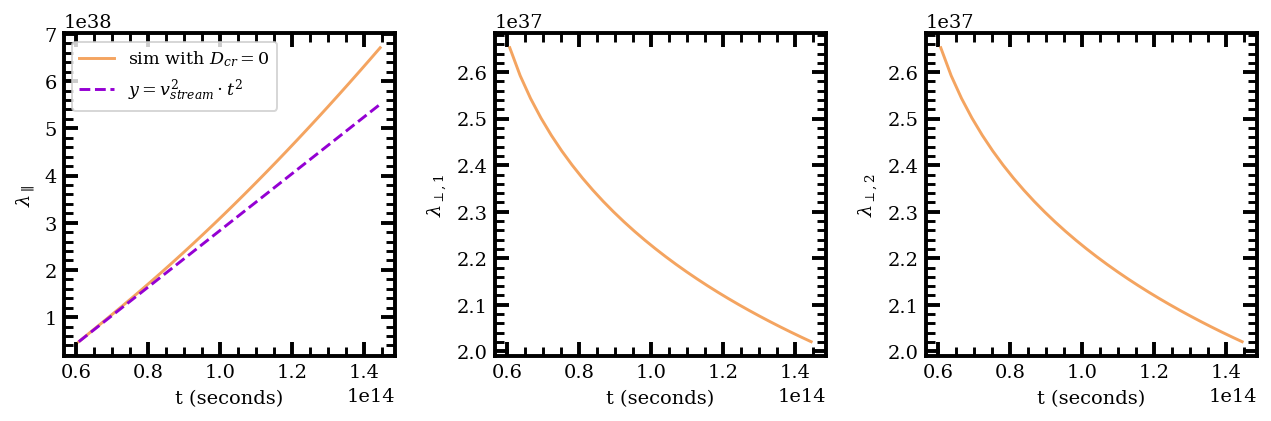

In [14]:
fig = plt.figure(figsize=(11,3), dpi=140)
plt.subplots_adjust(wspace=0.3,hspace=0.4)

# group 2
v_str = B_cgs / np.sqrt(7e-23)
diff = v_str**2 * (time2[-1] - time2[0])
end1 = eig21[0] + 2 * diff * (time2[-1] - time2[0]) 

# analytic functions
ana1 = np.linspace(eig21[0], end1,len(time2))

# plot the beast
plt.subplot(1,3,1)
plt.plot(time2, eig21, color='sandybrown',label=r"sim with $D_{cr}= 0$")
plt.plot(time2, ana1, ls='--', color='darkviolet', label=r"$y = v_{stream}^2 \cdot t^2$")
plt.legend(fontsize=9)
plt.ylabel(r'$\lambda_{\parallel}$')
plt.xlabel('t (seconds)')

plt.subplot(1,3,2)
plt.plot(time2, eig22, color='sandybrown')
plt.ylabel(r'$\lambda_{\perp,1}$')
plt.xlabel('t (seconds)')
plt.subplot(1,3,3)

plt.plot(time2, eig23, color='sandybrown')
plt.ylabel(r'$\lambda_{\perp,2}$')
plt.xlabel('t (seconds)')

plt.savefig("res64_no_turb_no_streaming_aniso.png")
#plt.savefig("res64_no_turb_no_streaming_aniso.pdf", tight_layout=True)

In [9]:
# naive gradient measurements -- assuming Gaussian diffusion
gradient = (eig21[-1] - eig21[0]) / (time2[-1] - time2[0]) / 2 # factor to go from MSD to diffusion coef
gradient2 = (eig22[-1] - eig22[0]) / (time2[-1] - time2[0]) / 2
gradient3 = (eig23[-1] - eig23[0]) / (time2[-1] - time2[0]) / 2

print(f"measured diff coef: {gradient}")
print(f"measured diff coef 2: {gradient2}")
print(f"measured diff coef 3: {gradient3}")

measured diff coef: 3.7151565949904704e+24
measured diff coef 2: -3.769327158549408e+22
measured diff coef 3: -3.7693427347155434e+22
